In [1]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [29]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

In [31]:
Xp = X.filter(regex = 'card_color').copy()
Xp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)
Xp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)

In [49]:
np.random.seed(10)
scaler = StandardScaler().fit(Xp)
X_s = scaler.transform(Xp)

size = np.min(np.unique(y[y != 'D'], return_counts = True)[1])
W = np.random.choice(np.arange(y.shape[0])[y == 'W'], size = size)
#D = np.random.choice(np.arange(y.shape[0])[y == 'D'], size = size)
L = np.random.choice(np.arange(y.shape[0])[y == 'L'], size = size)

idx = [W, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])
X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size = 0.2, stratify = y_i)

In [50]:
weights

{'W': 1.0, 'L': 2.061224489795918}

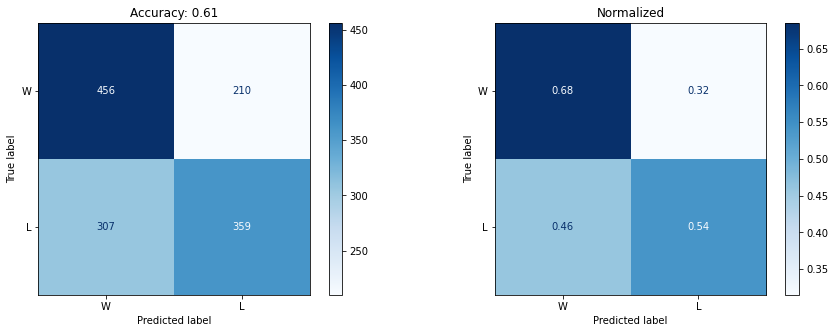

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.684685   0.597641  0.684685  0.638209      666
1      L  0.539039   0.630931  0.539039  0.581377      666
2  Total  0.611862   0.614286  0.611862  0.609793     1332


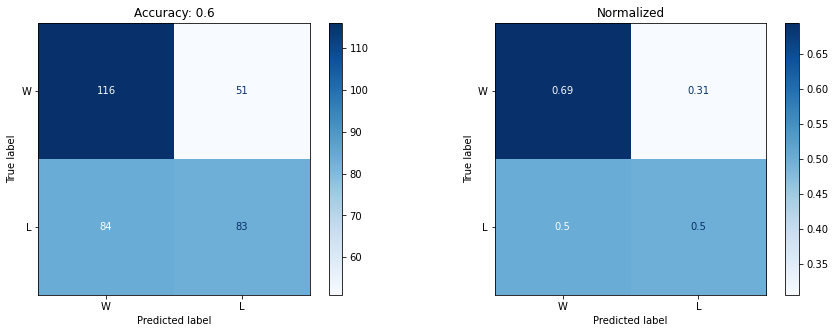

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.694611   0.580000  0.694611  0.632153      167
1      L  0.497006   0.619403  0.497006  0.551495      167
2  Total  0.595808   0.599701  0.595808  0.591824      334


In [55]:
params = {
    #'class_weight': weights,
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L']))

In [65]:
pd.DataFrame({"feature" : Xp.columns,"importance":np.e**clf.coef_[0]}).sort_values(by = 'importance', ascending = False)

,feature,importance
3,away_team_card_color_y2,1.057055
5,away_team_card_color_r,1.051260
6,home_fouls,0.995879
7,away_fouls,0.986425
4,home_team_card_color_r,0.930341
2,home_team_card_color_y2,0.926968
1,away_team_card_color_y,0.925517
0,home_team_card_color_y,0.808338


### With elo

In [94]:
X = data[data.columns[9:]].drop(['result'],axis = 1)
y = data['result']
Xp = X.filter(regex = 'card_color|elo').copy()
Xp['home_fouls'] = X.filter(regex = 'home_team_foul').sum(axis = 1)
Xp['away_fouls'] = X.filter(regex = 'away_team_foul').sum(axis = 1)

In [95]:
Xp = Xp.iloc[30:].reset_index(drop = True)
y = y.iloc[30:].reset_index(drop = True)

In [101]:
np.random.seed(10)
scaler = StandardScaler().fit(Xp)
X_s = scaler.transform(Xp)

'''size = np.min(np.unique(y, return_counts = True)[1])
W = np.random.choice(y.index[y == 'W'], size = size)
D = np.random.choice(y.index[y == 'D'], size = size)
L = np.random.choice(y.index[y == 'L'], size = size)

idx = [W, D, L]
new_idx = np.concatenate(idx)
X_i = X_s[new_idx]
y_i = y[new_idx]

weights = {}
for i, class_ in enumerate(['W', 'D', 'L']):
    weights[class_] = y[y == class_].shape[0]/len(idx[i])'''
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size = 0.2, stratify = y)

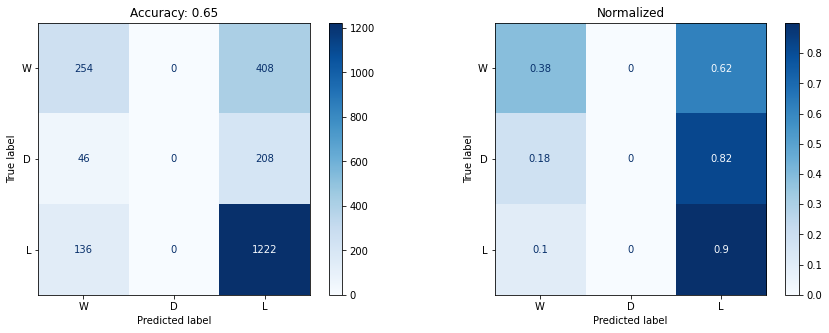

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.383686   0.582569  0.383686  0.462659      662
1      D  0.000000   0.000000  0.000000  0.000000      254
2      L  0.899853   0.664853  0.899853  0.764706     1358
3  Total  0.649077   0.566636  0.649077  0.591359     2274


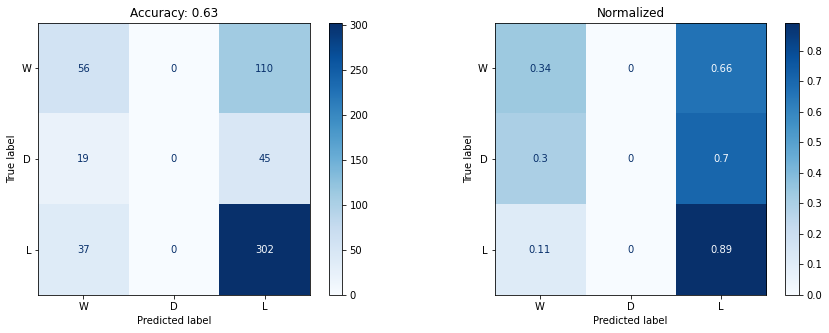

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.337349   0.500000  0.337349  0.402878      166
1      D  0.000000   0.000000  0.000000  0.000000       64
2      L  0.890855   0.660832  0.890855  0.758794      339
3  Total  0.629174   0.539582  0.629174  0.569611      569


In [102]:
params = {
    #'class_weight': weights,
    'multi_class' : 'multinomial'
}
clf = LogisticRegression(**params).fit(X_train, y_train)

print(metric_suite(clf, X_train, y_train, labels = ['W', 'D','L']))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'D','L']))